In [1]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


In [2]:
from copy import copy

palette = copy(plt.cm.viridis)
palette.set_over('magenta', 1.0)
palette.set_under('black', 1.0)
palette.set_bad('magenta', 1.0)

In [3]:
from matplotlib import colors
from scipy.signal import find_peaks

Load the color coding based on [yeun-opencolors](https://yeun.github.io/open-color/). 

In [4]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [5]:
annotations = pd.read_csv('refs/SARS-CoV-2-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1

# Non Leader
#cdsanno = annotations[(annotations['type'] == 'CDS') &
#                      (~annotations['name'].isin(['ORF10', 'nsp11', 'frameshift']))]

# Leader
cdsanno = annotations[(annotations['type'] == 'CDS') &
                      (~annotations['name'].isin(['ORF10', 'nsp1', 'frameshift'])) &
                      (~annotations['name'].apply(lambda x: x.startswith('nsp')))]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 265, 13467, 0.0, '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13467, 21552, 0.0, '.', '.'], index=cdsanno.columns),
    ])
]).sort_values(by='start').reset_index(drop=True).iloc[:, :5]

cdsanno

,chrom,type,name,start,end
0,chrSCV,CDS,ORF1a,265,13467
1,chrSCV,CDS,ORF1b,13467,21552
2,chrSCV,CDS,S,21562,25384
3,chrSCV,CDS,ORF3a,25392,26220
4,chrSCV,CDS,E,26244,26472
5,chrSCV,CDS,M,26522,27191
6,chrSCV,CDS,ORF6,27201,27387
7,chrSCV,CDS,ORF7a,27393,27759
8,chrSCV,CDS,ORF7b,27755,27887
9,chrSCV,CDS,ORF8,27893,28259


# Figure S2: Discontinuous mappings detected using DRS

In [6]:
!zcat junctions/VeroInf24h.large_deletions.bed.gz | head

chrSCV	62	26467	adfef58c-4dbe-4761-8834-0e043dc7a51c#0	0	+
chrSCV	68	28257	efbfdf49-9848-4e54-878c-75b79daa6879#0	0	+
chrSCV	64	27383	ea64786c-a20c-4c33-837e-4c7858a12a11#0	0	+
chrSCV	69	26236	ccb244ef-e35b-4daf-a707-86ebf1d4a614#0	0	+
chrSCV	66	27384	29ce6b33-d6b1-48cf-b968-d193727d78f5#0	0	+
chrSCV	64	25381	88641dbc-2c5e-48cf-a088-7b6b64e52606#0	0	+
chrSCV	64	28254	8c6a947d-aa70-4668-ba79-06cab430b188#0	0	+
chrSCV	66	27384	4b367765-0172-43ea-b3f3-071a6f90793c#0	0	+
chrSCV	62	28253	8fd02d67-6d6e-469d-a766-4a33218823eb#0	0	+
chrSCV	66	25381	64d13868-bc4f-44ce-8c15-8571b07b7c01#0	0	+

gzip: stdout: Broken pipe


In [7]:
largedels_nanopore = \
pd.read_csv('junctions/VeroInf24h.large_deletions.bed.gz', compression='gzip',
           names=['chrom', 'j5', 'j3', 'read_id', 'score', 'strand'], sep='\t')

In [8]:
largedels_nanopore

,chrom,j5,j3,read_id,score,strand
0,chrSCV,62,26467,adfef58c-4dbe-4761-8834-0e043dc7a51c#0,0,+
1,chrSCV,68,28257,efbfdf49-9848-4e54-878c-75b79daa6879#0,0,+
2,chrSCV,64,27383,ea64786c-a20c-4c33-837e-4c7858a12a11#0,0,+
3,chrSCV,69,26236,ccb244ef-e35b-4daf-a707-86ebf1d4a614#0,0,+
4,chrSCV,66,27384,29ce6b33-d6b1-48cf-b968-d193727d78f5#0,0,+
...,...,...,...,...,...,...
428213,chrSCV,64,26467,720c1181-a75d-4afd-8889-d8ca4d7c581e#0,0,+
428214,chrSCV,64,26467,9841aa8a-0dbf-4d71-b99e-b8b0e5e0bcbf#0,0,+
428215,chrSCV,76,26480,eb49a313-9fcd-4ad0-a6ee-7b57b51342b3#0,0,+
428216,chrSCV,68,28257,e22c6685-7fcb-4f73-a5fc-6c947e3861f6#0,0,+


In [9]:
tilesize = 100

largedels_nanopore['j5_tile'] = ((largedels_nanopore['j5'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_nanopore['j3_tile'] = ((largedels_nanopore['j3'] // tilesize) * tilesize + tilesize/2).astype(int)

In [10]:
((largedels_nanopore['j3'] - largedels_nanopore['j5']) < 20).sum()

0

In [11]:
tiled_counts = \
largedels_nanopore.groupby(['j5_tile', 'j3_tile']).agg({
    'strand': 'count'}).reset_index()
trv = tiled_counts.pivot(index='j5_tile', columns='j3_tile', values=['strand']).fillna(0).astype(int)

In [12]:
juncdensity = np.log2(trv+1).T.values

In [13]:
juncdensity.shape

(299, 299)

In [14]:
juncdensity[np.triu_indices(juncdensity.shape[0], k=1, m=None)] = np.nan

In [15]:
PADSIZE = 4
jdpadded = np.hstack([juncdensity[:, :1]] * PADSIZE + [juncdensity])
print(jdpadded.shape)

(299, 303)


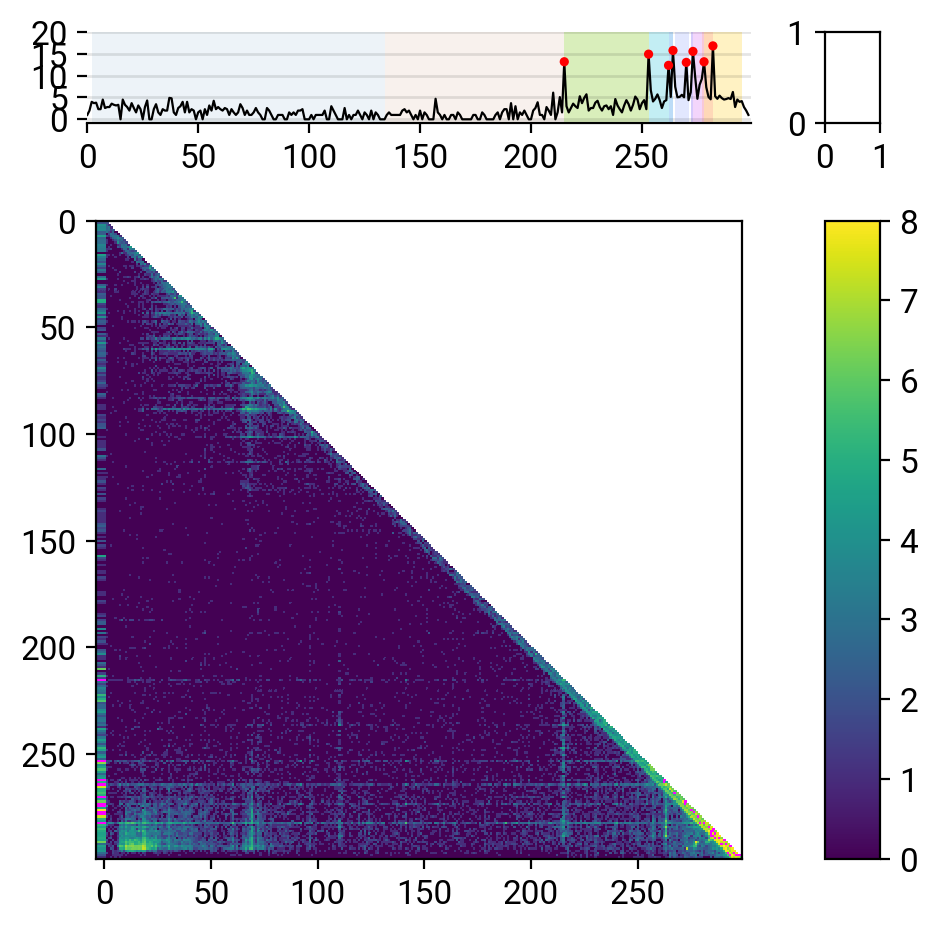

In [16]:
COLORMAX = 8
NUMBINS = juncdensity.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(4.8, 4.8),
                         gridspec_kw={'width_ratios': [12, 1], 'height_ratios': [1, 7]})

ax = axes[0, 0]
trsl_density = np.log2(trv['strand'].iloc[0]+1).values
ax.plot(np.arange(len(trsl_density)), trsl_density, c='black', lw=.8, zorder=2)
for sp in 'top left right'.split():
    ax.spines[sp].set_visible(False)
peakpos = find_peaks(trsl_density, prominence=4, height=8)[0]
ax.scatter(peakpos, [trsl_density[p] for p in peakpos],
           c='red', s=11, edgecolor='none', zorder=3)
for _, cds in cdsanno.iterrows():
    color = orfcolors[cds['name']]
    ax.axvspan(cds['start'] // tilesize, cds['end'] // tilesize, fc=color,
               alpha=.3)
ax.set_xticks(np.arange(0, NUMBINS+1, 50))
ax.set_xlim(0, NUMBINS)
ax.yaxis.grid(True, lw=1, c='black', alpha=.1)
ax.set_yticks(np.arange(0, 21, 5))

ax = axes[1, 0]
cbo = ax.pcolor(jdpadded, cmap=palette,
                norm=colors.Normalize(vmin=0, vmax=COLORMAX),
                rasterized=True)
ax.set_xticks(np.arange(0, NUMBINS, 50) + PADSIZE)
ax.set_aspect(1)
ax.set_xlim(0, jdpadded.shape[1])
ax.set_xticklabels(np.arange(0, NUMBINS, 50))
ax.invert_yaxis()

plt.colorbar(cbo, shrink=.6, cax=axes[1, 1])
plt.tight_layout()
plt.savefig('figure-outputs/plot-junctions-nanopore.pdf', dpi=600)

# Figure 3A: Discontinuous mappings detected using MGISEQ RNA-seq

In [17]:
largedels_mgi = \
    pd.read_csv('mgiseq/jumpstats/VeroSCV2.jumps.txt.gz',
               compression='gzip', names=['j5', 'j3', 'count'], sep='\t')

In [18]:
len(largedels_mgi)

224610

In [19]:
tilesize = 100

largedels_mgi['j5_tile'] = ((largedels_mgi['j5'] // tilesize) * tilesize + tilesize/2).astype(int)
largedels_mgi['j3_tile'] = ((largedels_mgi['j3'] // tilesize) * tilesize + tilesize/2).astype(int)

In [20]:
tiled_counts = \
largedels_mgi.groupby(['j5_tile', 'j3_tile']).agg({
    'count': 'sum'}).reset_index()
trv = tiled_counts.pivot(index='j5_tile', columns='j3_tile', values=['count']).fillna(0).astype(int)

In [21]:
juncdensity = np.log2(trv+1).T.values

In [22]:
juncdensity.shape

(299, 299)

In [23]:
juncdensity[np.triu_indices(juncdensity.shape[0], k=1, m=None)] = np.nan

In [24]:
juncdensity

array([[ 1.        ,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 3.70043972,  0.        ,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  1.        ,  1.5849625 , ...,         nan,
                nan,         nan],
       ...,
       [ 8.37503943,  1.        ,  2.        , ...,  9.73640193,
                nan,         nan],
       [ 4.7548875 ,  3.32192809,  2.32192809, ..., 10.59618976,
        13.95918693,         nan],
       [ 0.        ,  0.        ,  0.        , ..., 11.12670447,
         8.39231742,  2.        ]])

In [25]:
PADSIZE = 4
jdpadded = np.hstack([juncdensity[:, :1]] * PADSIZE + [juncdensity])
print(jdpadded.shape)

(299, 303)


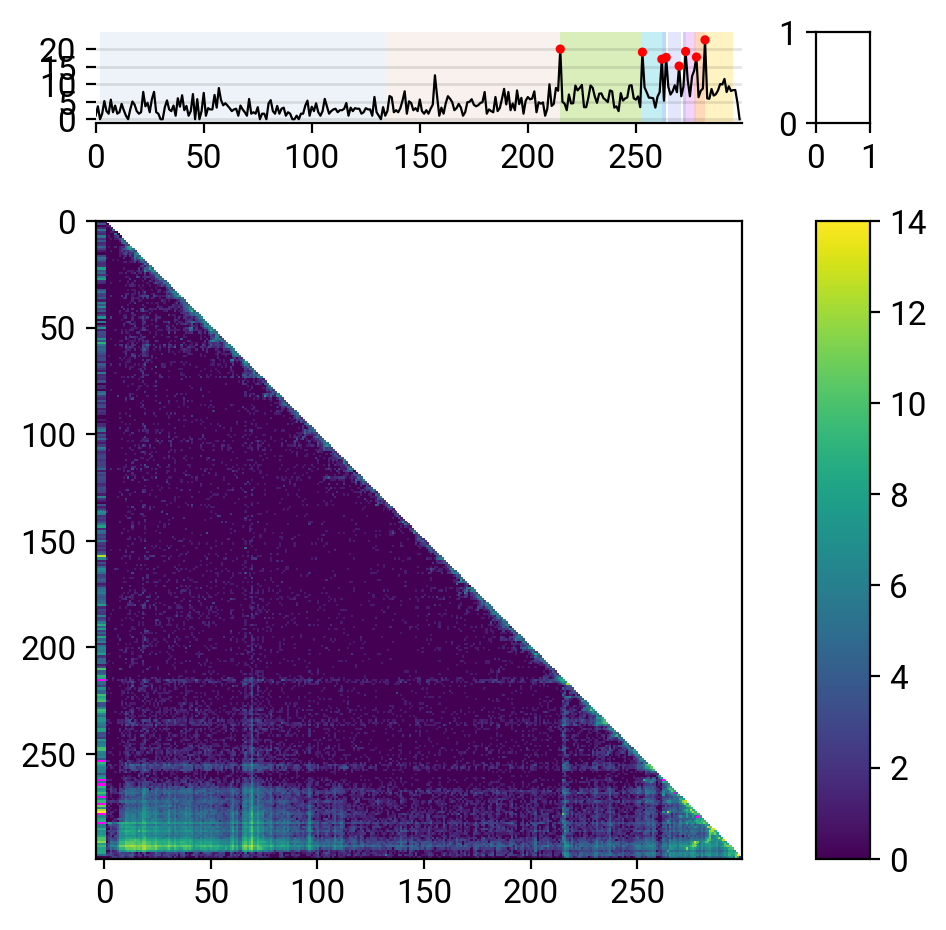

In [26]:
COLORMAX = 14
NUMBINS = jdpadded.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(4.8, 4.8),
                         gridspec_kw={'width_ratios': [12, 1], 'height_ratios': [1, 7]})

ax = axes[0, 0]
trsl_density = np.log2(trv['count'].iloc[0]+1).values
ax.plot(np.arange(len(trsl_density)), trsl_density, c='black', lw=.8, zorder=2)
for sp in 'top left right'.split():
    ax.spines[sp].set_visible(False)
peakpos = find_peaks(trsl_density, prominence=8, height=13)[0]
ax.scatter(peakpos, [trsl_density[p] for p in peakpos],
           c='red', s=11, edgecolor='none', zorder=3)
for _, cds in cdsanno.iterrows():
    color = orfcolors[cds['name']]
    ax.axvspan(cds['start'] // tilesize, cds['end'] // tilesize, fc=color,
               alpha=.3)
ax.set_xticks(np.arange(0, NUMBINS+1, 50))
ax.set_xlim(0, NUMBINS)
ax.yaxis.grid(True, lw=1, c='black', alpha=.1)
ax.set_yticks(np.arange(0, 21, 5))

ax = axes[1, 0]
cbo = ax.pcolor(jdpadded, cmap=palette,
                norm=colors.Normalize(vmin=0, vmax=COLORMAX),
                rasterized=True)
ax.set_xticks(np.arange(0, NUMBINS, 50) + PADSIZE)
ax.set_aspect(1)
ax.set_xlim(0, jdpadded.shape[1])
ax.set_xticklabels(np.arange(0, NUMBINS, 50))
ax.invert_yaxis()

plt.colorbar(cbo, shrink=.6, cax=axes[1, 1])
plt.tight_layout()
plt.savefig('figure-outputs/plot-junctions-mgiseq.pdf', dpi=600)